In [205]:
library(forcats)
library(readxl)
library(ggplot2)
library(gridExtra)
library(dplyr)
library(leaps)
library(pROC)
library(stats)
library(bestglm)
library(glmnet)
library(ROCR)
library(caret)
library(FactoMineR) 
library(MASS)
library(factoextra)
library(mclust)
library(labelled)
library(tidyverse)
library(viridis)

In [329]:
insa <- read_excel("C:/Users/pauld/Desktop/Stats/Projet_4A_INSA/general/survey.xlsx")
insa <- as.data.frame(insa)
insa <- insa[,1:53]
insa <- insa %>% rename(Tiers_Temps = Tiers_temps...9)
insa <- insa %>% rename(Presence_CM = Presence_CM...16)
insa <- insa %>% rename(Presence_TD = Presence_TD...17)
insa <- insa %>% rename(Presence_TP = Presence_TP...18)
insa <- insa %>% rename(sortie_nuit = `Frequence_bar/boite`)
insa <- mutate_all(insa, as.factor)
str(insa)
head(insa)

New names:
• `Tiers_temps` -> `Tiers_temps...9`
• `Presence_CM` -> `Presence_CM...16`
• `Presence_TD` -> `Presence_TD...17`
• `Presence_TP` -> `Presence_TP...18`
• `Tiers_temps` -> `Tiers_temps...90`
• `Presence_CM` -> `Presence_CM...133`
• `Presence_TD` -> `Presence_TD...134`
• `Presence_TP` -> `Presence_TP...135`
• `` -> `...415`
• `` -> `...416`
• `` -> `...417`
• `` -> `...418`
• `` -> `...419`


'data.frame':	1185 obs. of  53 variables:
 $ id                   : Factor w/ 1185 levels "3","4","5","8",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ trajet               : Factor w/ 4 levels "10min","15min",..: 2 1 4 1 1 1 2 2 4 4 ...
 $ logement             : Factor w/ 3 levels "colocation","foyer familial",..: 3 3 3 3 1 1 3 3 3 3 ...
 $ surf_logement        : Factor w/ 5 levels "- 10m2","+ 30m2",..: 2 2 3 2 5 5 4 2 3 4 ...
 $ sent_logement        : Factor w/ 4 levels "pas du tout",..: 4 4 3 4 4 4 4 4 3 3 ...
 $ act_pro              : Factor w/ 5 levels "aucune","oui +15h",..: 1 1 1 1 1 3 1 2 1 1 ...
 $ Bourse               : Factor w/ 4 levels "echelon 0bis-2",..: 2 4 4 4 4 4 4 4 1 4 ...
 $ handicap             : Factor w/ 2 levels "non","oui": 1 1 1 1 1 1 1 1 1 2 ...
 $ Tiers_Temps          : Factor w/ 2 levels "Non","Oui": 1 1 1 1 2 1 1 1 1 2 ...
 $ Stress               : Factor w/ 4 levels "jamais","parfois",..: 3 3 3 4 3 4 4 3 3 3 ...
 $ travail_sem          : Factor w/ 5 levels "+4h","0-1h

,id,trajet,logement,surf_logement,sent_logement,act_pro,Bourse,handicap,Tiers_Temps,Stress,⋯,Sensation_reussite,Adequation_projet_pro,Promo,Spe/PO,Cohorte,Bac_origine,Resultat_1A,Resultat_preced,Redoublement,Rattrapages
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,3,15min,seul,+ 30m2,tout à fait,aucune,echelon 3-6,non,Non,souvent,⋯,plutôt non,plutôt oui,4A,GMM,classique,Fr,pas de classement,25-50%,Non,aucun
2,4,10min,seul,+ 30m2,tout à fait,aucune,non,non,Non,souvent,⋯,tout à fait,tout à fait,4A,GMM,classique,Fr,0-10%,0-10%,Non,aucun
3,5,5min,seul,10-20m2,plutôt oui,aucune,non,non,Non,souvent,⋯,plutôt oui,plutôt oui,4A,GMM,classique,Fr,50-75%,25-50%,Non,aucun
4,8,10min,seul,+ 30m2,tout à fait,aucune,non,non,Non,toujours,⋯,plutôt oui,plutôt non,4A,GB,classique,Fr,25-50%,10-25%,Non,aucun
5,9,10min,colocation,coloc ou foyer familial,tout à fait,aucune,non,non,Oui,souvent,⋯,plutôt oui,tout à fait,4A,GB,classique,Fr,pas de classement,50-75%,Oui,1 par semestre
6,11,10min,colocation,coloc ou foyer familial,tout à fait,oui 1/5h,non,non,Non,toujours,⋯,plutôt non,plutôt oui,4A,GB,classique,Fr,50-75%,jsp,Oui,2/3 par semestre


In [330]:
insa <- filter(insa, Resultat_preced == "0-10%" | Resultat_preced == "10-25%" | Resultat_preced == "25-50%" | Resultat_preced == "50-75%" | Resultat_preced == "75-100%" | Resultat_preced == "redoubl" | Resultat_preced == "amenag")
insa <- filter(insa, Promo == "2A" | Promo == "3A" | Promo == "4A" | Promo == "5A")
insa <- na.omit(insa)
str(insa)
head(insa)
missing_data <- colMeans(is.na(insa)) * 100

sorted_missing_data <- sort(missing_data, decreasing = TRUE)

cat("Pourcentage de données manquantes par variable (ordre décroissant):\n")
for (i in seq_along(sorted_missing_data)) {
  cat(names(sorted_missing_data)[i], ": ", sprintf("%.2f", sorted_missing_data[i]), "%\n")
}

'data.frame':	743 obs. of  53 variables:
 $ id                   : Factor w/ 1185 levels "3","4","5","8",..: 1 2 3 4 5 8 9 10 11 12 ...
 $ trajet               : Factor w/ 4 levels "10min","15min",..: 2 1 4 1 1 2 4 4 4 1 ...
 $ logement             : Factor w/ 3 levels "colocation","foyer familial",..: 3 3 3 3 1 3 3 3 3 1 ...
 $ surf_logement        : Factor w/ 5 levels "- 10m2","+ 30m2",..: 2 2 3 2 5 2 3 4 3 5 ...
 $ sent_logement        : Factor w/ 4 levels "pas du tout",..: 4 4 3 4 4 4 3 3 3 4 ...
 $ act_pro              : Factor w/ 5 levels "aucune","oui +15h",..: 1 1 1 1 1 2 1 1 1 3 ...
 $ Bourse               : Factor w/ 4 levels "echelon 0bis-2",..: 2 4 4 4 4 4 1 4 2 4 ...
 $ handicap             : Factor w/ 2 levels "non","oui": 1 1 1 1 1 1 1 2 1 1 ...
 $ Tiers_Temps          : Factor w/ 2 levels "Non","Oui": 1 1 1 1 2 1 1 2 1 1 ...
 $ Stress               : Factor w/ 4 levels "jamais","parfois",..: 3 3 3 4 3 3 3 3 3 3 ...
 $ travail_sem          : Factor w/ 5 levels "+4h","0-1

,id,trajet,logement,surf_logement,sent_logement,act_pro,Bourse,handicap,Tiers_Temps,Stress,⋯,Sensation_reussite,Adequation_projet_pro,Promo,Spe/PO,Cohorte,Bac_origine,Resultat_1A,Resultat_preced,Redoublement,Rattrapages
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,3,15min,seul,+ 30m2,tout à fait,aucune,echelon 3-6,non,Non,souvent,⋯,plutôt non,plutôt oui,4A,GMM,classique,Fr,pas de classement,25-50%,Non,aucun
2,4,10min,seul,+ 30m2,tout à fait,aucune,non,non,Non,souvent,⋯,tout à fait,tout à fait,4A,GMM,classique,Fr,0-10%,0-10%,Non,aucun
3,5,5min,seul,10-20m2,plutôt oui,aucune,non,non,Non,souvent,⋯,plutôt oui,plutôt oui,4A,GMM,classique,Fr,50-75%,25-50%,Non,aucun
4,8,10min,seul,+ 30m2,tout à fait,aucune,non,non,Non,toujours,⋯,plutôt oui,plutôt non,4A,GB,classique,Fr,25-50%,10-25%,Non,aucun
5,9,10min,colocation,coloc ou foyer familial,tout à fait,aucune,non,non,Oui,souvent,⋯,plutôt oui,tout à fait,4A,GB,classique,Fr,pas de classement,50-75%,Oui,1 par semestre
6,14,15min,seul,+ 30m2,tout à fait,oui +15h,non,non,Non,souvent,⋯,plutôt oui,plutôt oui,3A,GB,classique,Fr_etranger,pas de classement,50-75%,Non,aucun


Pourcentage de données manquantes par variable (ordre décroissant):
id :  0.00 %
trajet :  0.00 %
logement :  0.00 %
surf_logement :  0.00 %
sent_logement :  0.00 %
act_pro :  0.00 %
Bourse :  0.00 %
handicap :  0.00 %
Tiers_Temps :  0.00 %
Stress :  0.00 %
travail_sem :  0.00 %
travail_wek :  0.00 %
Travail_groupe :  0.00 %
Travail_ext :  0.00 %
Travail_dom :  0.00 %
Presence_CM :  0.00 %
Presence_TD :  0.00 %
Presence_TP :  0.00 %
Notes_cours :  0.00 %
Concentration_CM :  0.00 %
Concentration_TD :  0.00 %
Concentration_TP :  0.00 %
Prep_CM :  0.00 %
Prep_TD :  0.00 %
Prep_TP :  0.00 %
revisions :  0.00 %
efficacite :  0.00 %
travail_cond :  0.00 %
ressources_sup :  0.00 %
Amis :  0.00 %
Famille :  0.00 %
isol :  0.00 %
associatif :  0.00 %
associatif_bien_etre :  0.00 %
associatif_fatigue :  0.00 %
sport :  0.00 %
Frequence_spectacle :  0.00 %
sortie_nuit :  0.00 %
detente :  0.00 %
ecrans :  0.00 %
sommeil :  0.00 %
alimentation :  0.00 %
Motivation :  0.00 %
Sensation_reussite :  0

In [331]:
insa <- subset(insa, select = -id)
insa <- subset(insa, select = -handicap)
insa <- subset(insa, select = -Presence_TP)
insa <- subset(insa, select = -associatif_bien_etre)
insa <- subset(insa, select = -associatif_fatigue)
insa <- subset(insa, select = -Tiers_Temps)
str(insa)

'data.frame':	743 obs. of  47 variables:
 $ trajet               : Factor w/ 4 levels "10min","15min",..: 2 1 4 1 1 2 4 4 4 1 ...
 $ logement             : Factor w/ 3 levels "colocation","foyer familial",..: 3 3 3 3 1 3 3 3 3 1 ...
 $ surf_logement        : Factor w/ 5 levels "- 10m2","+ 30m2",..: 2 2 3 2 5 2 3 4 3 5 ...
 $ sent_logement        : Factor w/ 4 levels "pas du tout",..: 4 4 3 4 4 4 3 3 3 4 ...
 $ act_pro              : Factor w/ 5 levels "aucune","oui +15h",..: 1 1 1 1 1 2 1 1 1 3 ...
 $ Bourse               : Factor w/ 4 levels "echelon 0bis-2",..: 2 4 4 4 4 4 1 4 2 4 ...
 $ Stress               : Factor w/ 4 levels "jamais","parfois",..: 3 3 3 4 3 3 3 3 3 3 ...
 $ travail_sem          : Factor w/ 5 levels "+4h","0-1h","0h",..: 2 1 4 4 2 5 4 4 4 2 ...
 $ travail_wek          : Factor w/ 7 levels "+8h","0-1h","0h",..: 5 5 6 7 6 1 6 6 5 5 ...
 $ Travail_groupe       : Factor w/ 4 levels "jamais","parfois",..: 1 1 2 2 2 2 2 3 3 3 ...
 $ Travail_ext          : Factor w/ 4 le

In [332]:
insa$trajet <- factor(insa$trajet,levels=c("10min","5min","15min","30min"))
insa$logement <- factor(insa$logement,levels=c("seul","colocation","foyer familial"))
insa$surf_logement <- fct_collapse(insa$surf_logement, "10-20m2"= c("10-20m2"), "20-30m2"=c("20-30m2"),"+ 30m2"=c("+ 30m2","coloc ou foyer familial"), "- 10m2"  = c("- 10m2"))
insa$surf_logement <- factor(insa$surf_logement,levels=c("10-20m2","- 10m2","20-30m2","+ 30m2"))
insa$sent_logement <- factor(insa$sent_logement,levels=c("plutôt oui","tout à fait","plutôt non","pas du tout"))
insa$act_pro <- fct_collapse(insa$act_pro, "non" = "aucune", "oui" = c("oui 1/5h","oui 5/10h","oui 10/15h","oui +15h"))
insa$act_pro <- factor(insa$act_pro,levels=c("non","oui"))
insa$Bourse <- fct_collapse(insa$Bourse, "non" = "non", "echelon 0bis-2" = "echelon 0bis-2", "echelon 3-7" = c("echelon 3-6","echelon 7"))
insa$Bourse <- factor(insa$Bourse,levels=c("non","echelon 0bis-2","echelon 3-7"))

In [333]:
insa$Stress <- fct_collapse(insa$Stress, "toujours" = "toujours", "souvent" = "souvent", "rarement" = c("parfois","jamais"))
insa$Stress <- factor(insa$Stress,levels=c("souvent","rarement","toujours"))
insa$travail_sem <- fct_collapse(insa$travail_sem, "0-1h" = c("0-1h","0h"), "1-2h" = "1-2h", "+2h" = c("2-4h","+4h"))
insa$travail_sem <- factor(insa$travail_sem,levels=c("1-2h","0-1h","+2h"))
insa$travail_wek <- fct_collapse(insa$travail_wek, "0-1h" = c("0-1h","0h"), "+8h" = "+8h", "1-2h" = "1-2h", "2-4h" = "2-4h", "4-6h" = "4-6h", "6-8h" = "6-8h")
insa$travail_wek <- factor(insa$travail_wek,levels=c("2-4h","+8h","6-8h","4-6h","0-1h","1-2h"))
insa$Travail_groupe <- fct_collapse(insa$Travail_groupe, "parfois" = "parfois", "souvent" = c("souvent","toujours"), "jamais" = "jamais")
insa$Travail_groupe <-factor(insa$Travail_groupe,levels=c("parfois","souvent","jamais"))
insa$Travail_ext <- fct_collapse(insa$Travail_ext, "parfois" = "parfois", "souvent" = c("souvent","toujours"), "jamais" = "jamais")
insa$Travail_ext <-factor(insa$Travail_ext,levels=c("parfois","souvent","jamais"))
insa$Travail_dom <- fct_collapse(insa$Travail_dom, "parfois" = c("parfois","jamais"), "souvent" = "souvent", "toujours" = "toujours")
insa$Travail_dom <-factor(insa$Travail_dom,levels=c("souvent","parfois","toujours"))
insa$Presence_CM <- fct_collapse(insa$Presence_CM, "parfois" = c("Parfois","Jamais"), "souvent" = "Souvent", "toujours" = "Toujours")
insa$Presence_CM <-factor(insa$Presence_CM,levels=c("souvent","toujours","parfois"))
insa$Presence_TD <- fct_collapse(insa$Presence_TD, "pas toujours" = c("Jamais","Parfois","Souvent"), "toujours" = "Toujours")
insa$Presence_TD <-factor(insa$Presence_TD,levels=c("toujours","pas toujours"))
insa$Notes_cours <- fct_collapse(insa$Notes_cours, "souvent" = "Souvent", "toujours" = "Toujours", "rarement" = c("Parfois","Jamais"))
insa$Notes_cours <-factor(insa$Notes_cours,levels=c("souvent","toujours","rarement"))

In [334]:
insa$Prep_CM <- fct_collapse(insa$Prep_CM, "jamais" = "Jamais", "parfois" = "Parfois", "souvent" = c("Souvent","Toujours"))
insa$Prep_CM <-factor(insa$Prep_CM,levels=c("parfois","jamais","souvent"))
insa$Prep_TD <- fct_collapse(insa$Prep_TD, "jamais" = "Jamais", "parfois" = "Parfois", "souvent" = c("Souvent","Toujours"))
insa$Prep_TD <-factor(insa$Prep_TD,levels=c("parfois","jamais","souvent"))
insa$Prep_TP <-factor(insa$Prep_TP,levels=c("Souvent","Toujours","Parfois","Jamais"))
insa$Concentration_CM <- fct_collapse(insa$Concentration_CM, "Moyennement concentré.e" = "Moyennement concentré.e", "Très peu concentré.e" = "Très peu concentré.e", "Assez bien concentré.e" = c("Assez bien concentré.e","Totalement concentré.e"))
insa$Concentration_CM <- factor(insa$Concentration_CM,levels=c("Moyennement concentré.e","Assez bien concentré.e","Très peu concentré.e"))
insa$Concentration_TD <- fct_collapse(insa$Concentration_TD, "Moyennement concentré.e" = c("Moyennement concentré.e","Très peu concentré.e"), "Assez bien concentré.e" = "Assez bien concentré.e", "Totalement concentré.e" = "Totalement concentré.e")
insa$Concentration_TD <- factor(insa$Concentration_TD,levels=c("Assez bien concentré.e","Moyennement concentré.e","Totalement concentré.e"))
insa$Concentration_TP <- fct_collapse(insa$Concentration_TP, "Moyennement concentré.e" = c("Moyennement concentré.e","Très peu concentré.e"), "Assez bien concentré.e" = "Assez bien concentré.e", "Totalement concentré.e" = "Totalement concentré.e")
insa$Concentration_TP <- factor(insa$Concentration_TP,levels=c("Assez bien concentré.e","Moyennement concentré.e","Totalement concentré.e"))

In [335]:
insa$revisions <- fct_collapse(insa$revisions, "1 semaine avant" = "1 semaine avant", "2 semaines avant" = "2 semaines avant", "3-4 jours avant" = c("3-4 jours avant","la veille"), "1 mois avant" = c("1 mois avant", "semestre"))
insa$revisions <-factor(insa$revisions,levels=c("1 semaine avant","1 mois avant","2 semaines avant","3-4 jours avant"))
insa$efficacite <- fct_collapse(insa$efficacite, "moyennement" = c("moyennement","pas du tout"), "plutôt oui" = "plutôt oui", "très" = "très")
insa$efficacite <-factor(insa$efficacite,levels=c("plutôt oui","très","moyennement"))
insa$travail_cond <- fct_collapse(insa$travail_cond, "moyennes" = c("moyennes","mauvaises"), "plutôt bonnes" = "plutôt bonnes", "très bonnes" = "très bonnes")
insa$travail_cond <-factor(insa$travail_cond,levels=c("plutôt bonnes","très bonnes","moyennes"))
insa$ressources_sup <-factor(insa$ressources_sup,levels=c("parfois","régulièrement","très souvent","jamais"))
insa$Amis <- fct_collapse(insa$Amis, "parfois" = c("parfois","jamais"), "régulièrement" = "régulièrement", "très souvent" = "très souvent")
insa$Amis <-factor(insa$Amis,levels=c("régulièrement","très souvent","parfois"))
insa$Famille <- factor(insa$Famille,levels=c("régulièrement","très souvent","parfois","jamais"))
insa$isol <- fct_collapse(insa$isol, "jamais" = "jamais", "parfois" = "parfois", "souvent" = c("souvent","toujours"))
insa$isol <-factor(insa$isol,levels=c("parfois","jamais","souvent"))
insa$associatif <- fct_collapse(insa$associatif, "0h" = "0h", "0-1h" = "0-1h", "1-5h" = "1-5h", "+5h" = c("5-10h","10-15h","15-20h","+ 20h"))
insa$associatif <-factor(insa$associatif,levels=c("0h","0-1h","1-5h","+5h"))
insa$sport <-factor(insa$sport,levels=c("1-3h","0-1h","3-6h","6-10h","+ 10h"))
insa$Frequence_spectacle <- fct_collapse(insa$Frequence_spectacle, "jamais" = "jamais", "rarement" = "rarement", "au moins 1/mois" = c("1/mois","1/semaine"))
insa$Frequence_spectacle <-factor(insa$Frequence_spectacle,levels=c("rarement","jamais","au moins 1/mois"))

In [336]:
insa$sortie_nuit <- fct_collapse(insa$sortie_nuit, "1/mois" = "1/mois", "1/semaine" = "1/semaine", "jamais" = "jamais", "rarement" = "rarement", "plusieurs fois/semaine" = c("plusieurs fois/semaine", "tous les jours"))
insa$sortie_nuit <-factor(insa$sortie_nuit,levels=c("1/mois","rarement","jamais","1/semaine","plusieurs fois/semaine"))
insa$detente <- fct_collapse(insa$detente, "parfois" = c("parfois","jamais"), "régulièrement" = "régulièrement", "très souvent" = "très souvent")
insa$detente <-factor(insa$detente,levels=c("régulièrement","très souvent","parfois"))
insa$ecrans <- fct_collapse(insa$ecrans, "0-2h" = c("0-1h","1-2h"), "2-4h" = "2-4h", "4-6h" = "4-6h", "+6h" = c("6-8h","+ 8h"))
insa$ecrans <- factor(insa$ecrans,levels=c("2-4h","0-2h","4-6h","+6h"))
insa$alimentation <- fct_collapse(insa$alimentation, "plutôt non" = c("pas du tout","plutôt non"), "plutôt oui" = "plutôt oui", "tout à fait" = "tout à fait")
insa$alimentation <- factor(insa$alimentation, levels=c("plutôt oui","tout à fait","plutôt non"))
insa$sommeil <- factor(insa$sommeil,levels=c("plutôt satisfaisante","très satifsfaisante","plutôt insatisfaisante","très insatisfaisante"))
insa$Motivation <- fct_collapse(insa$Motivation, "plutôt non" = c("pas du tout","plutôt non"), "plutôt oui" = "plutôt oui", "tout à fait" = "tout à fait")
insa$Motivation <- factor(insa$Motivation, levels=c("plutôt oui","tout à fait","plutôt non"))
insa$Adequation_projet_pro <- fct_collapse(insa$Adequation_projet_pro, "plutôt non" = c("pas du tout","plutôt non"), "plutôt oui" = "plutôt oui", "tout à fait" = "tout à fait")
insa$Adequation_projet_pro <- factor(insa$Adequation_projet_pro, levels=c("plutôt oui","tout à fait","plutôt non"))
insa$Promo <- fct_collapse(insa$Promo, "2A"= c("1A","2A"), "3A" = c("3A"), "4A/5A" = c("4A","5A"))
insa$Promo <- factor(insa$Promo,levels=c("2A","3A","4A/5A"))
insa$`Spe/PO` <- fct_collapse(insa$`Spe/PO`, "IMACS"= c("1A","AE","GP","IMACS"), "MIC" = c("GMM","IR","MIC"), "ICBE" = c("GB","GP3E","ICBE"), "IC" = c("GC","GM","IC"))

#### 1) 0-25% vs others

In [12]:
insa$Resultat_preced <- fct_collapse(insa$Resultat_preced, "0-25%"= c("0-10%","10-25%"), "25-100%" = c("25-50%","50-75%","75-100%","jsp"))
insa$Resultat_preced <- factor(insa$Resultat_preced,levels=c("25-100%","0-25%"))
table(insa$Resultat_preced)


25-100%   0-25% 
    427     316 

In [64]:
log.lm <- glm(Resultat_preced ~ act_pro + surf_logement + trajet + logement + sent_logement + Bourse + Stress + travail_sem + travail_wek + Travail_groupe +
                 Travail_ext + Travail_dom + Presence_CM + Presence_TD + Notes_cours + Prep_CM + Concentration_CM + Concentration_TD + Concentration_TP + Prep_TD + Prep_TP + revisions + efficacite + travail_cond + ressources_sup +
                 Famille + Amis + isol + associatif + sport + Frequence_spectacle + sortie_nuit + detente + ecrans + sommeil + alimentation + Motivation + Adequation_projet_pro, data = insa, family = binomial)
anova(log.lm, test = "Chisq")
summary(log.lm)

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,742,1013.3717,NA
act_pro,1,0.02693564,741,1013.3448,0.8696360384
surf_logement,3,9.58159890,738,1003.7632,0.0224789438
trajet,3,2.11066538,735,1001.6525,0.5497580988
logement,2,0.29415726,733,1001.3583,0.8632260997
sent_logement,3,1.74799416,730,999.6103,0.6263168315
Bourse,2,2.15481163,728,997.4555,0.3404776437
Stress,2,0.12839883,726,997.3271,0.9378179639
travail_sem,2,1.00585657,724,996.3213,0.6047571625



Call:
glm(formula = Resultat_preced ~ act_pro + surf_logement + trajet + 
    logement + sent_logement + Bourse + Stress + travail_sem + 
    travail_wek + Travail_groupe + Travail_ext + Travail_dom + 
    Presence_CM + Presence_TD + Notes_cours + Prep_CM + Concentration_CM + 
    Concentration_TD + Concentration_TP + Prep_TD + Prep_TP + 
    revisions + efficacite + travail_cond + ressources_sup + 
    Famille + Amis + isol + associatif + sport + Frequence_spectacle + 
    sortie_nuit + detente + ecrans + sommeil + alimentation + 
    Motivation + Adequation_projet_pro, family = binomial, data = insa)

Coefficients:
                                         Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -0.480486   0.522664  -0.919 0.357938
act_prooui                               0.144607   0.258702   0.559 0.576180
surf_logement- 10m2                     -1.190637   0.649413  -1.833 0.066742
surf_logement20-30m2                     0.244805   0.221280  

In [65]:
log.lm.step <- step(log.lm, direction = "backward")

Start:  AIC=1080.45
Resultat_preced ~ act_pro + surf_logement + trajet + logement + 
    sent_logement + Bourse + Stress + travail_sem + travail_wek + 
    Travail_groupe + Travail_ext + Travail_dom + Presence_CM + 
    Presence_TD + Notes_cours + Prep_CM + Concentration_CM + 
    Concentration_TD + Concentration_TP + Prep_TD + Prep_TP + 
    revisions + efficacite + travail_cond + ressources_sup + 
    Famille + Amis + isol + associatif + sport + Frequence_spectacle + 
    sortie_nuit + detente + ecrans + sommeil + alimentation + 
    Motivation + Adequation_projet_pro

                        Df Deviance    AIC
- sortie_nuit            4   898.69 1074.7
- sport                  4   898.79 1074.8
- associatif             3   897.12 1075.1
- ecrans                 3   897.17 1075.2
- trajet                 3   897.39 1075.4
- Famille                3   897.41 1075.4
- Prep_TP                3   898.20 1076.2
- travail_wek            5   902.29 1076.3
- Concentration_TP       2   896.45

In [66]:
anova(log.lm.step, test = "Chisq")
summary(log.lm.step)

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,742,1013.3717,NA
surf_logement,3,9.532750,739,1003.8389,0.0229854950
Travail_dom,2,10.272647,737,993.5663,0.0058792663
Presence_CM,2,16.346236,735,977.2201,0.0002821369
Notes_cours,2,8.524669,733,968.6954,0.0140893749
Frequence_spectacle,2,7.250463,731,961.4449,0.0266429250
Adequation_projet_pro,2,14.056124,729,947.3888,0.0008866486



Call:
glm(formula = Resultat_preced ~ surf_logement + Travail_dom + 
    Presence_CM + Notes_cours + Frequence_spectacle + Adequation_projet_pro, 
    family = binomial, data = insa)

Coefficients:
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                        -0.52080    0.22257  -2.340  0.01929 *  
surf_logement- 10m2                -1.15733    0.57760  -2.004  0.04510 *  
surf_logement20-30m2                0.24712    0.20056   1.232  0.21789    
surf_logement+ 30m2                 0.11916    0.18392   0.648  0.51703    
Travail_domparfois                 -0.50808    0.20065  -2.532  0.01134 *  
Travail_domtoujours                 0.19817    0.18740   1.057  0.29030    
Presence_CMtoujours                 0.76090    0.18311   4.156 3.25e-05 ***
Presence_CMparfois                 -0.36023    0.22351  -1.612  0.10703    
Notes_courstoujours                 0.06275    0.18703   0.335  0.73727    
Notes_coursrarement                 0.633

In [67]:
exp(log.lm.step$coefficients)

(Intercept)                surf_logement- 10m2 
                         0.5940444                          0.3143228 
              surf_logement20-30m2                surf_logement+ 30m2 
                         1.2803362                          1.1265538 
                Travail_domparfois                Travail_domtoujours 
                         0.6016487                          1.2191674 
               Presence_CMtoujours                 Presence_CMparfois 
                         2.1401939                          0.6975174 
               Notes_courstoujours                Notes_coursrarement 
                         1.0647555                          1.8848483 
         Frequence_spectaclejamais Frequence_spectacleau moins 1/mois 
                         0.6254756                          1.0773778 
  Adequation_projet_protout à fait    Adequation_projet_proplutôt non 
                         0.5426059                          1.2284792

In [68]:
anova(log.lm.step, log.lm, test="Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,729,947.3888,NA,NA,NA
2,651,896.4454,78,50.94341,0.9924294


In [40]:
insa$Presence_CM <- fct_collapse(insa$Presence_CM, "pas toujours" = c("parfois","souvent"), "toujours" = "toujours")
insa$Presence_CM <-factor(insa$Presence_CM,levels=c("pas toujours","toujours"))

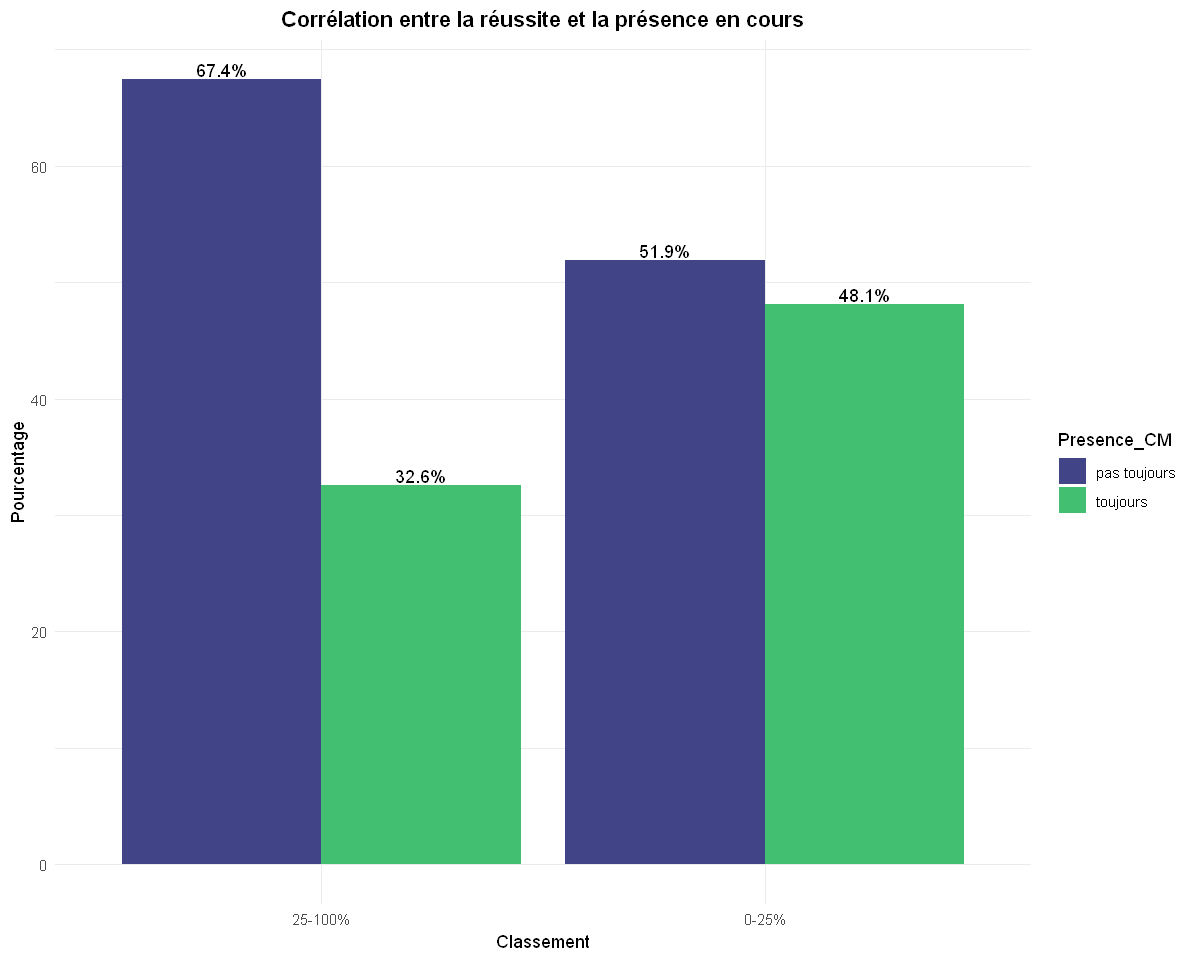

In [196]:
options(repr.plot.width = 10, repr.plot.height = 8)
contingency_table <- insa %>%
  dplyr::count(Presence_CM, Resultat_preced) %>%
  dplyr::group_by(Resultat_preced) %>%
  dplyr::mutate(percentage = (n / sum(n)) * 100)
ggplot(contingency_table, aes(x = Resultat_preced, y = percentage, fill = Presence_CM)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_viridis(discrete = TRUE, option = "D", begin = 0.2, end = 0.7) +
  geom_text(aes(label = sprintf("%.1f%%", percentage)), 
            position = position_dodge(width = 0.9), vjust = -0.25) +
  labs(x = "Classement", y = "Pourcentage", title = "Corrélation entre la réussite et la présence en cours") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

In [81]:
insa$Adequation_projet_pro <- factor(insa$Adequation_projet_pro, levels = c("plutôt non", "plutôt oui", "tout à fait"))

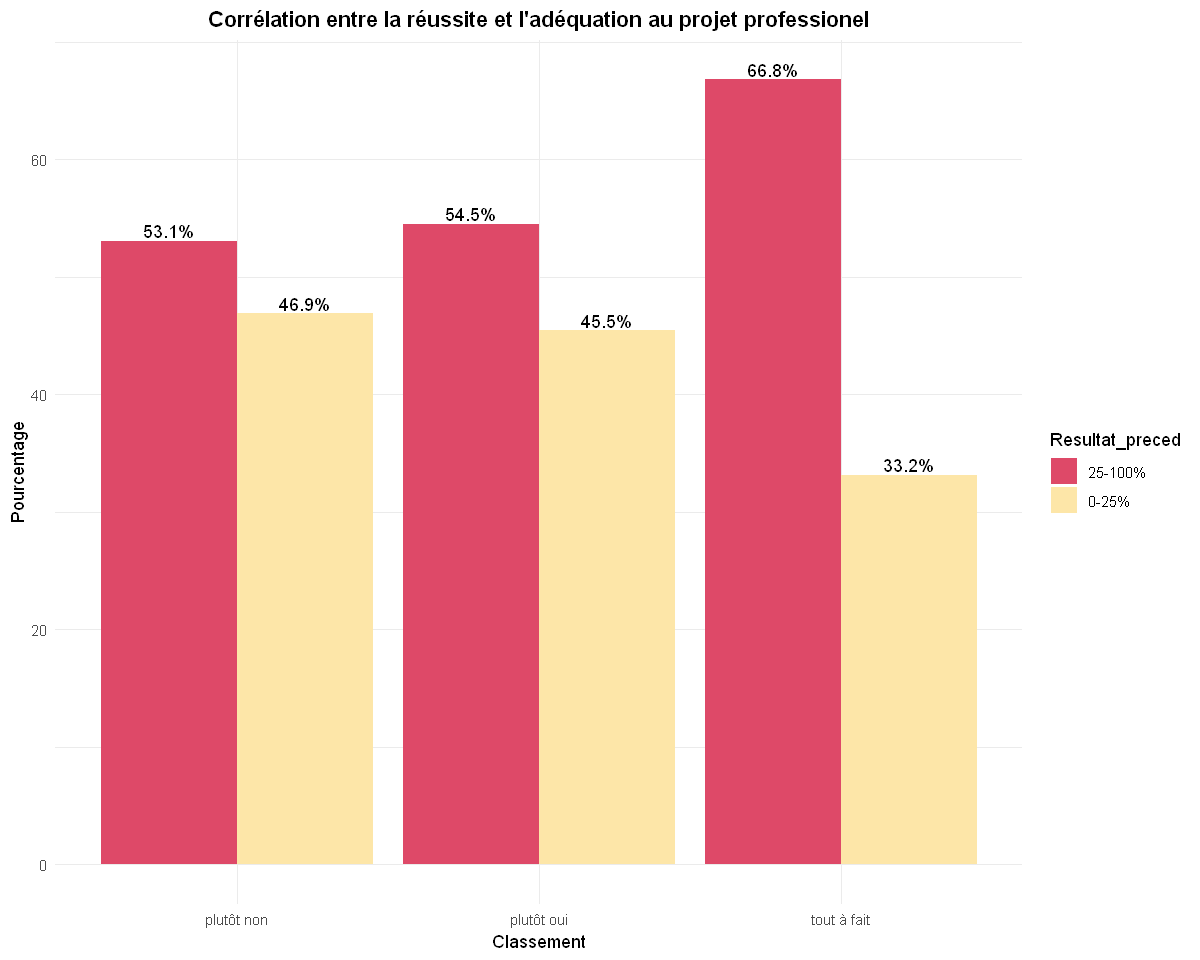

In [175]:
options(repr.plot.width = 10, repr.plot.height = 8)
contingency_table <- insa %>%
  dplyr::count(Resultat_preced, Adequation_projet_pro) %>%
  dplyr::group_by(Adequation_projet_pro) %>%
  dplyr::mutate(percentage = (n / sum(n)) * 100)
ggplot(contingency_table, aes(x = Adequation_projet_pro, y = percentage, fill = Resultat_preced)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_viridis(discrete = TRUE, option = "A", begin = 0.6, end = 0.95) +
  geom_text(aes(label = sprintf("%.1f%%", percentage)), 
            position = position_dodge(width = 0.9), vjust = -0.25) +
  labs(x = "Classement", y = "Pourcentage", title = "Corrélation entre la réussite et l'adéquation au projet professionel") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

In [178]:
insa$surf_logement <- fct_collapse(insa$surf_logement, "+ 20m2" = c("+ 30m2","20-30m2"), "- 10m2" = "- 10m2", "10-20m2" = "10-20m2")
insa$surf_logement <- factor(insa$surf_logement, levels = c("- 10m2", "10-20m2", "+ 20m2"))

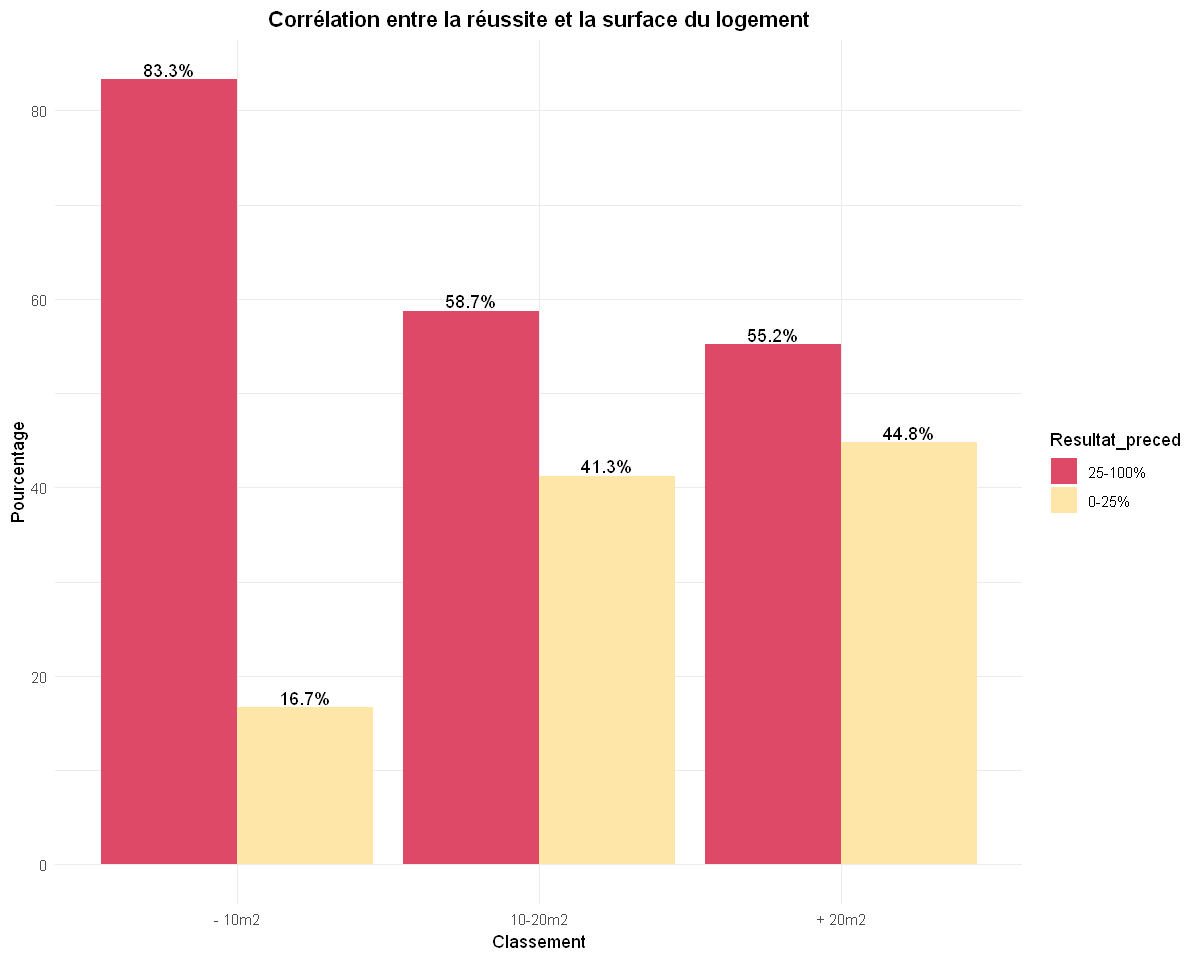

In [180]:
options(repr.plot.width = 10, repr.plot.height = 8)
contingency_table <- insa %>%
  dplyr::count(Resultat_preced, surf_logement) %>%
  dplyr::group_by(surf_logement) %>%
  dplyr::mutate(percentage = (n / sum(n)) * 100)
ggplot(contingency_table, aes(x = surf_logement, y = percentage, fill = Resultat_preced)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_viridis(discrete = TRUE, option = "A", begin = 0.6, end = 0.95) +
  geom_text(aes(label = sprintf("%.1f%%", percentage)), 
            position = position_dodge(width = 0.9), vjust = -0.25) +
  labs(x = "Classement", y = "Pourcentage", title = "Corrélation entre la réussite et la surface du logement") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

In [185]:
insa$Travail_dom <- factor(insa$Travail_dom, levels = c("toujours", "souvent", "parfois"))

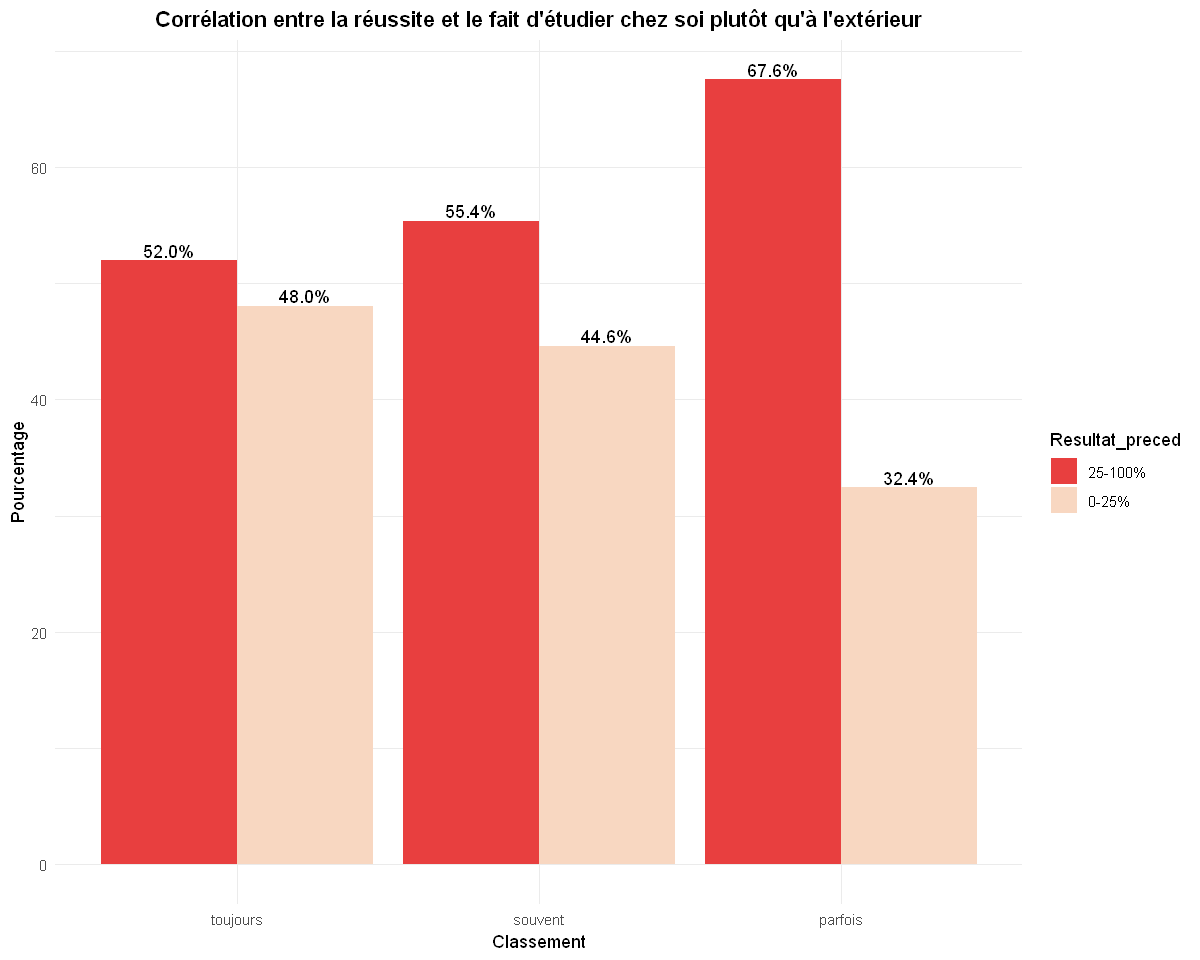

In [200]:
options(repr.plot.width = 10, repr.plot.height = 8)
contingency_table <- insa %>%
  dplyr::count(Resultat_preced, Travail_dom) %>%
  dplyr::group_by(Travail_dom) %>%
  dplyr::mutate(percentage = (n / sum(n)) * 100)
ggplot(contingency_table, aes(x = Travail_dom, y = percentage, fill = Resultat_preced)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_viridis(discrete = TRUE, option = "F", begin = 0.6, end = 0.95) +
  geom_text(aes(label = sprintf("%.1f%%", percentage)), 
            position = position_dodge(width = 0.9), vjust = -0.25) +
  labs(x = "Classement", y = "Pourcentage", title = "Corrélation entre la réussite et le fait d'étudier chez soi plutôt qu'à l'extérieur") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

In [202]:
insa$Frequence_spectacle <- factor(insa$Frequence_spectacle, levels = c("au moins 1/mois", "rarement", "jamais"))

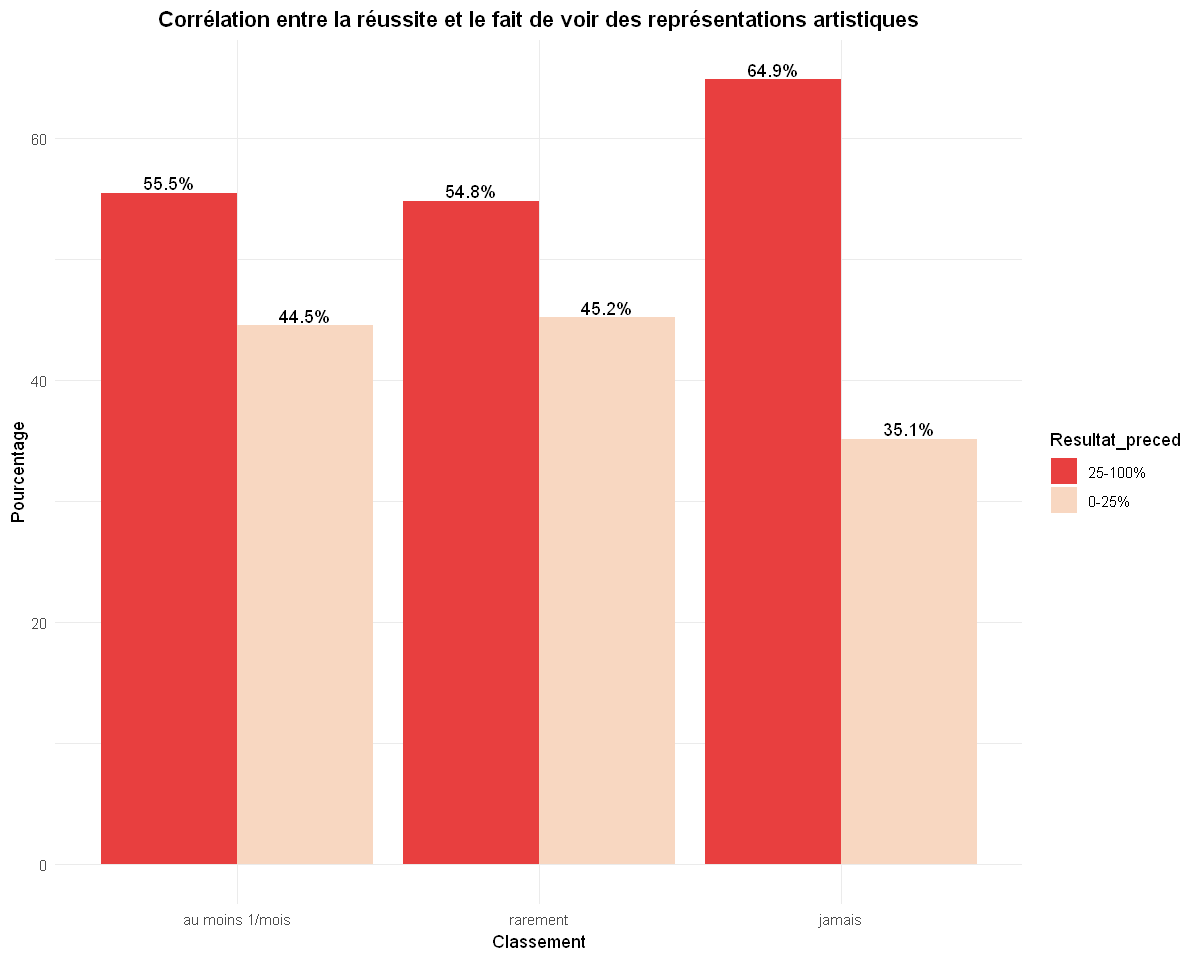

In [204]:
options(repr.plot.width = 10, repr.plot.height = 8)
contingency_table <- insa %>%
  dplyr::count(Resultat_preced, Frequence_spectacle) %>%
  dplyr::group_by(Frequence_spectacle) %>%
  dplyr::mutate(percentage = (n / sum(n)) * 100)
ggplot(contingency_table, aes(x = Frequence_spectacle, y = percentage, fill = Resultat_preced)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_viridis(discrete = TRUE, option = "F", begin = 0.6, end = 0.95) +
  geom_text(aes(label = sprintf("%.1f%%", percentage)), 
            position = position_dodge(width = 0.9), vjust = -0.25) +
  labs(x = "Classement", y = "Pourcentage", title = "Corrélation entre la réussite et le fait de voir des représentations artistiques") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

Si on devait résumer en quelques points :
- La présence en cours s'avère être fondamentale. De plus, travailler chez soi semble être aussi important, et plus corrélé à la réussite que le fait de travailler en groupe/à l'insa ou extérieur. 
- Une dimension sociale aussi : les gens ayant un petit logement, ou assitant jamais à des représentations artistiques réussissent moins bien. (voir aussi alimentation, bourse).
- Enfin, remarque étonnante : l'adéquation au projet pro n'est pas corrélé à la réussite. Rejoint l'exemple donné par Jean Yves Dauxois, sur cette étudiante sentant très bien les données, à l'aise en tp, et pourtant avec des notes moyennes.

#### 2) 50-100% vs others

In [325]:
insa$Resultat_preced <- fct_collapse(insa$Resultat_preced, "50-100%"= c("50-75%","jsp","75-100%"), "0-50%" = c("25-50%","0-10%","10-25%"))
insa$Resultat_preced <- factor(insa$Resultat_preced,levels=c("0-50%","50-100%"))
table(insa$Resultat_preced)


  0-50% 50-100% 
    536     207 

In [216]:
log.lm <- glm(Resultat_preced ~ act_pro + surf_logement + trajet + logement + sent_logement + Bourse + Stress + travail_sem + travail_wek + Travail_groupe +
                 Travail_ext + Travail_dom + Presence_CM + Presence_TD + Notes_cours + Prep_CM + Concentration_CM + Concentration_TD + Concentration_TP + Prep_TD + Prep_TP + revisions + efficacite + travail_cond + ressources_sup +
                 Famille + Amis + isol + associatif + sport + Frequence_spectacle + sortie_nuit + detente + ecrans + sommeil + alimentation + Motivation + Adequation_projet_pro, data = insa, family = binomial)
anova(log.lm, test = "Chisq")
summary(log.lm)

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,742,879.1569,NA
act_pro,1,0.05582801,741,879.1011,0.813215777
surf_logement,3,5.54861554,738,873.5525,0.135759613
trajet,3,8.00461341,735,865.5479,0.045916457
logement,2,1.38144837,733,864.1664,0.501212966
sent_logement,3,0.39865844,730,863.7678,0.940519489
Bourse,2,2.54449760,728,861.2233,0.280200798
Stress,2,0.03575341,726,861.1875,0.982282138
travail_sem,2,0.57652134,724,860.6110,0.749566179



Call:
glm(formula = Resultat_preced ~ act_pro + surf_logement + trajet + 
    logement + sent_logement + Bourse + Stress + travail_sem + 
    travail_wek + Travail_groupe + Travail_ext + Travail_dom + 
    Presence_CM + Presence_TD + Notes_cours + Prep_CM + Concentration_CM + 
    Concentration_TD + Concentration_TP + Prep_TD + Prep_TP + 
    revisions + efficacite + travail_cond + ressources_sup + 
    Famille + Amis + isol + associatif + sport + Frequence_spectacle + 
    sortie_nuit + detente + ecrans + sommeil + alimentation + 
    Motivation + Adequation_projet_pro, family = binomial, data = insa)

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -1.3657131  0.5933476  -2.302  0.02135
act_prooui                              -0.0004737  0.2925992  -0.002  0.99871
surf_logement- 10m2                      1.0082303  0.5318867   1.896  0.05802
surf_logement20-30m2                     0.0632420  0.2547

In [217]:
log.lm.step <- step(log.lm, direction = "backward")

Start:  AIC=928
Resultat_preced ~ act_pro + surf_logement + trajet + logement + 
    sent_logement + Bourse + Stress + travail_sem + travail_wek + 
    Travail_groupe + Travail_ext + Travail_dom + Presence_CM + 
    Presence_TD + Notes_cours + Prep_CM + Concentration_CM + 
    Concentration_TD + Concentration_TP + Prep_TD + Prep_TP + 
    revisions + efficacite + travail_cond + ressources_sup + 
    Famille + Amis + isol + associatif + sport + Frequence_spectacle + 
    sortie_nuit + detente + ecrans + sommeil + alimentation + 
    Motivation + Adequation_projet_pro

                        Df Deviance    AIC
- sport                  4   745.65 921.65
- ecrans                 3   744.23 922.23
- sent_logement          3   744.62 922.62
- Prep_TP                3   745.16 923.16
- Concentration_CM       2   744.19 924.19
- Travail_dom            2   744.22 924.22
- Stress                 2   744.37 924.37
- Notes_cours            2   744.37 924.37
- Motivation             2   744.61 924

In [218]:
anova(log.lm.step, test = "Chisq")
summary(log.lm.step)

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,742,879.1569,NA
surf_logement,3,5.578509,739,873.5784,0.134017614
trajet,3,8.025844,736,865.5526,0.045480603
Bourse,2,2.720358,734,862.8322,0.256614803
Travail_ext,2,3.971954,732,858.8603,0.137246437
Presence_CM,2,10.940381,730,847.9199,0.004210431
Presence_TD,1,2.862263,729,845.0576,0.090679817
Concentration_TP,2,8.341219,727,836.7164,0.015442847
efficacite,2,6.704383,725,830.0120,0.035007549



Call:
glm(formula = Resultat_preced ~ surf_logement + trajet + Bourse + 
    Travail_ext + Presence_CM + Presence_TD + Concentration_TP + 
    efficacite + ressources_sup + Frequence_spectacle + detente + 
    sommeil + Adequation_projet_pro, family = binomial, data = insa)

Coefficients:
                                         Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -1.329464   0.323656  -4.108    4e-05
surf_logement- 10m2                      1.079169   0.474918   2.272  0.02307
surf_logement20-30m2                     0.041632   0.233026   0.179  0.85821
surf_logement+ 30m2                     -0.399157   0.245157  -1.628  0.10349
trajet5min                              -0.492468   0.216541  -2.274  0.02295
trajet15min                             -0.051627   0.250721  -0.206  0.83686
trajet30min                              0.617516   0.418818   1.474  0.14037
Bourseechelon 0bis-2                    -0.275262   0.232570  -1.184  0.23658
Boursee

In [219]:
anova(log.lm.step, log.lm, test="Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,713,787.1515,NA,NA,NA
2,651,744.0018,62,43.14963,0.967234


In [290]:
insa$surf_logement <- fct_collapse(insa$surf_logement, "+ 20m2" = c("+ 30m2","20-30m2"), "- 10m2" = "- 10m2", "10-20m2" = "10-20m2")
insa$surf_logement <- factor(insa$surf_logement, levels = c("- 10m2", "10-20m2", "+ 20m2"))

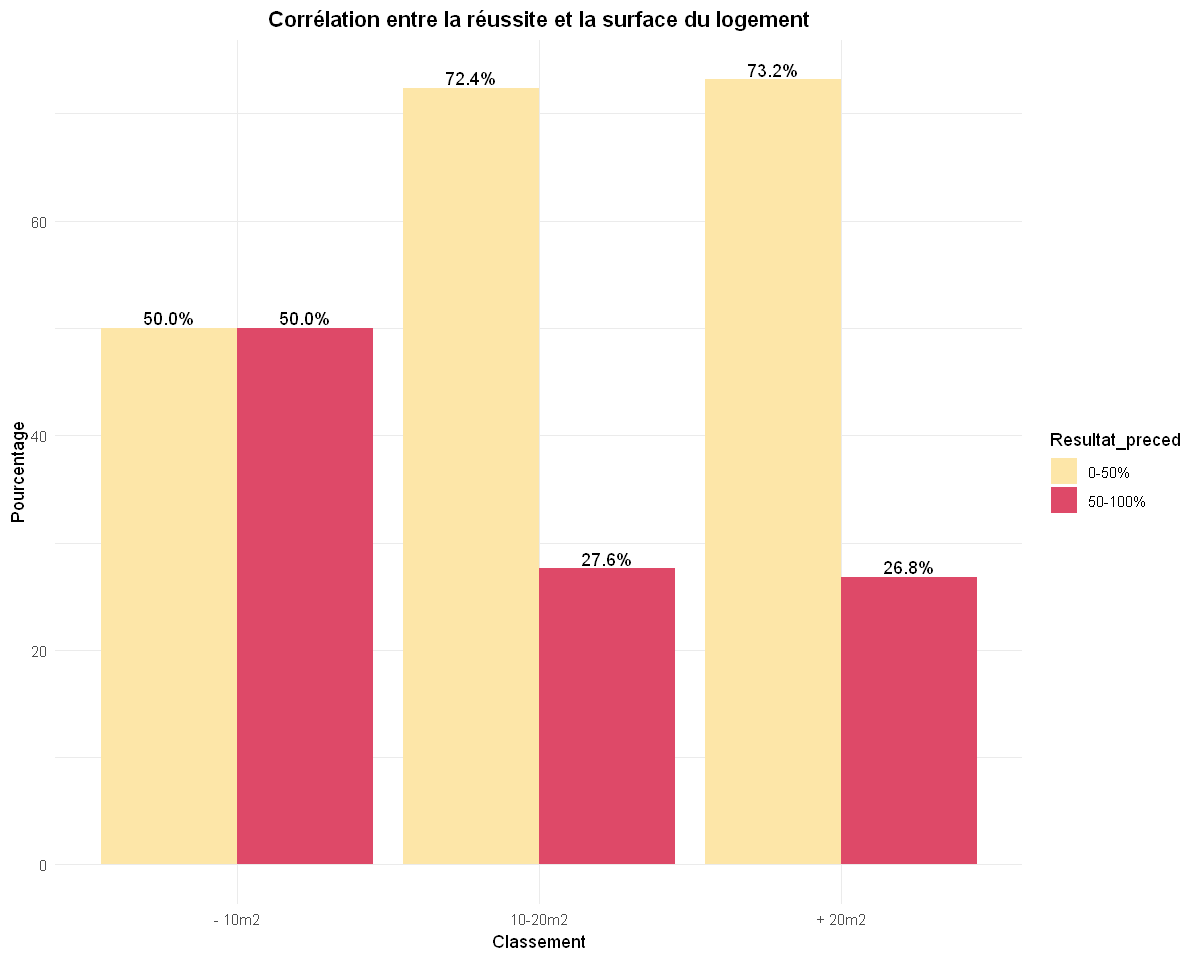

In [296]:
options(repr.plot.width = 10, repr.plot.height = 8)
contingency_table <- insa %>%
  dplyr::count(Resultat_preced, surf_logement) %>%
  dplyr::group_by(surf_logement) %>%
  dplyr::mutate(percentage = (n / sum(n)) * 100)
ggplot(contingency_table, aes(x = surf_logement, y = percentage, fill = Resultat_preced)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_viridis(discrete = TRUE, option = "A", begin = 0.95, end = 0.6) +
  geom_text(aes(label = sprintf("%.1f%%", percentage)), 
            position = position_dodge(width = 0.9), vjust = -0.25) +
  labs(x = "Classement", y = "Pourcentage", title = "Corrélation entre la réussite et la surface du logement") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

In [281]:
insa$sommeil <- factor(insa$sommeil, levels = c("très satifsfaisante", "plutôt satisfaisante", "plutôt insatisfaisante", "très insatisfaisante"))

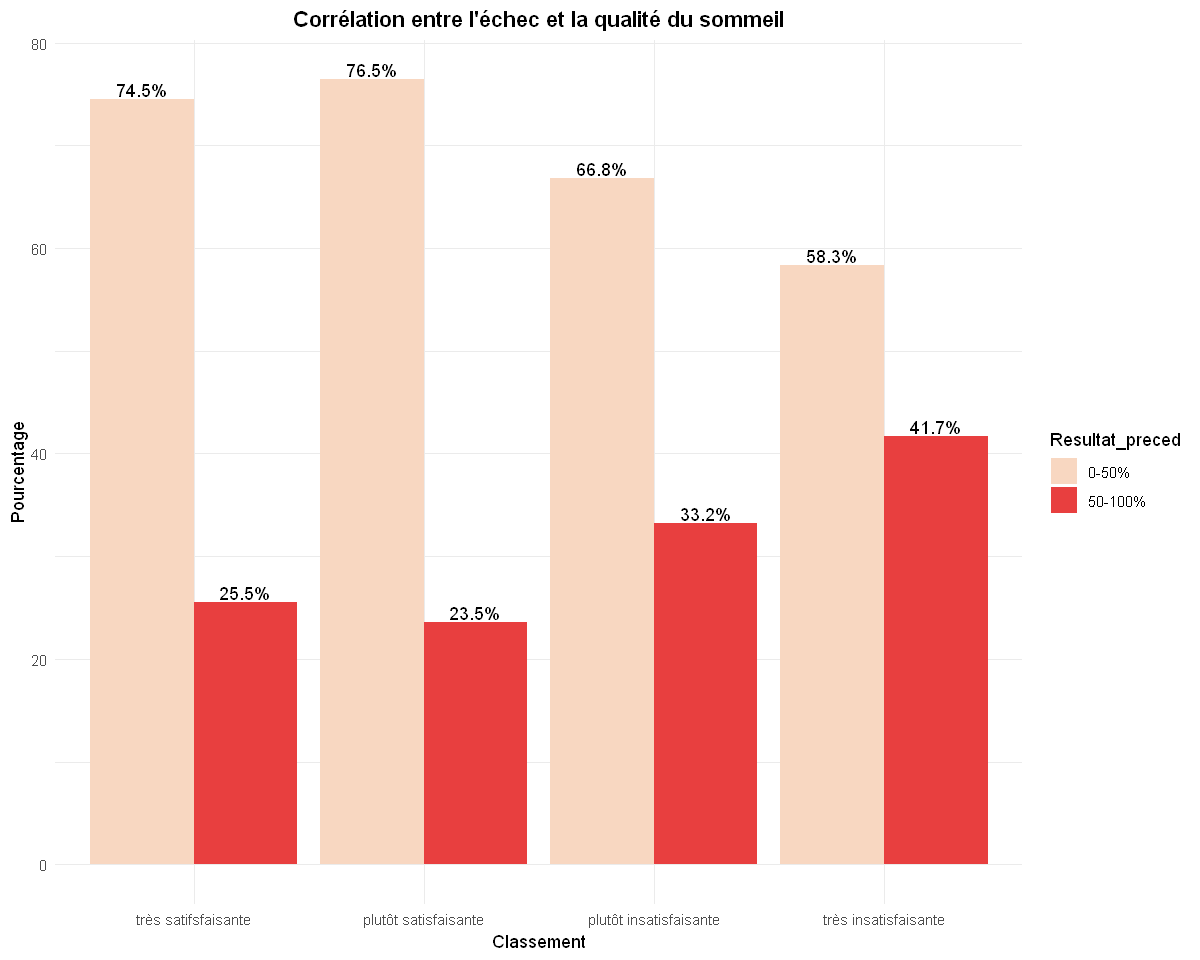

In [295]:
options(repr.plot.width = 10, repr.plot.height = 8)
contingency_table <- insa %>%
  dplyr::count(Resultat_preced, sommeil) %>%
  dplyr::group_by(sommeil) %>%
  dplyr::mutate(percentage = (n / sum(n)) * 100)
ggplot(contingency_table, aes(x = sommeil, y = percentage, fill = Resultat_preced)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_viridis(discrete = TRUE, option = "F", begin = 0.95, end = 0.6) +
  geom_text(aes(label = sprintf("%.1f%%", percentage)), 
            position = position_dodge(width = 0.9), vjust = -0.25) +
  labs(x = "Classement", y = "Pourcentage", title = "Corrélation entre l'échec et la qualité du sommeil") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

In [292]:
insa$Adequation_projet_pro <- factor(insa$Adequation_projet_pro, levels = c("plutôt non", "plutôt oui", "tout à fait"))

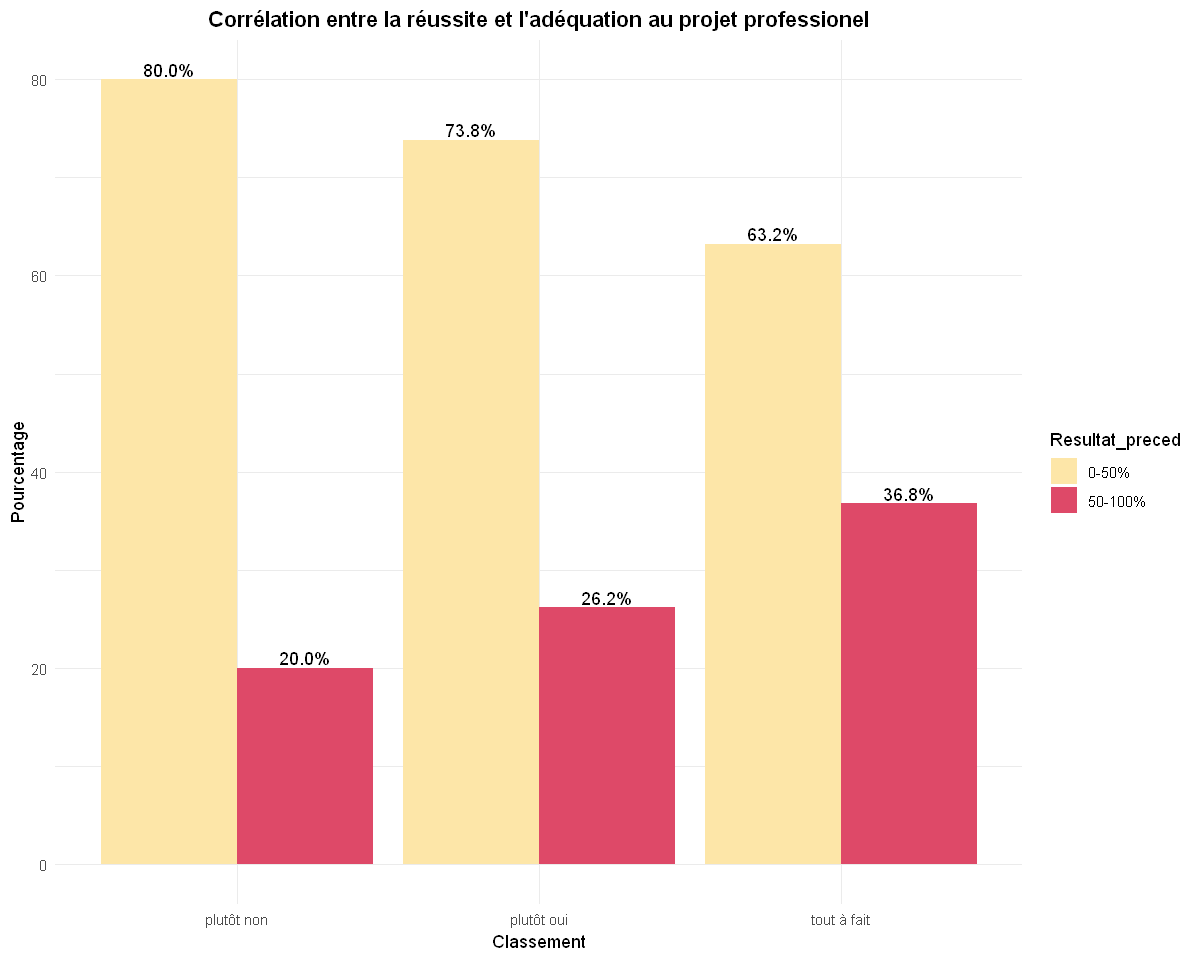

In [294]:
options(repr.plot.width = 10, repr.plot.height = 8)
contingency_table <- insa %>%
  dplyr::count(Resultat_preced, Adequation_projet_pro) %>%
  dplyr::group_by(Adequation_projet_pro) %>%
  dplyr::mutate(percentage = (n / sum(n)) * 100)
ggplot(contingency_table, aes(x = Adequation_projet_pro, y = percentage, fill = Resultat_preced)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_viridis(discrete = TRUE, option = "A", begin = 0.95, end = 0.6) +
  geom_text(aes(label = sprintf("%.1f%%", percentage)), 
            position = position_dodge(width = 0.9), vjust = -0.25) +
  labs(x = "Classement", y = "Pourcentage", title = "Corrélation entre la réussite et l'adéquation au projet professionel") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

In [326]:
insa$ressources_sup <- fct_collapse(insa$ressources_sup, "régulièrement" = c("régulièrement","très souvent"), "parfois" = "parfois", "jamais" = "jamais")
insa$ressources_sup <- factor(insa$ressources_sup, levels = c("jamais", "parfois", "régulièrement"))

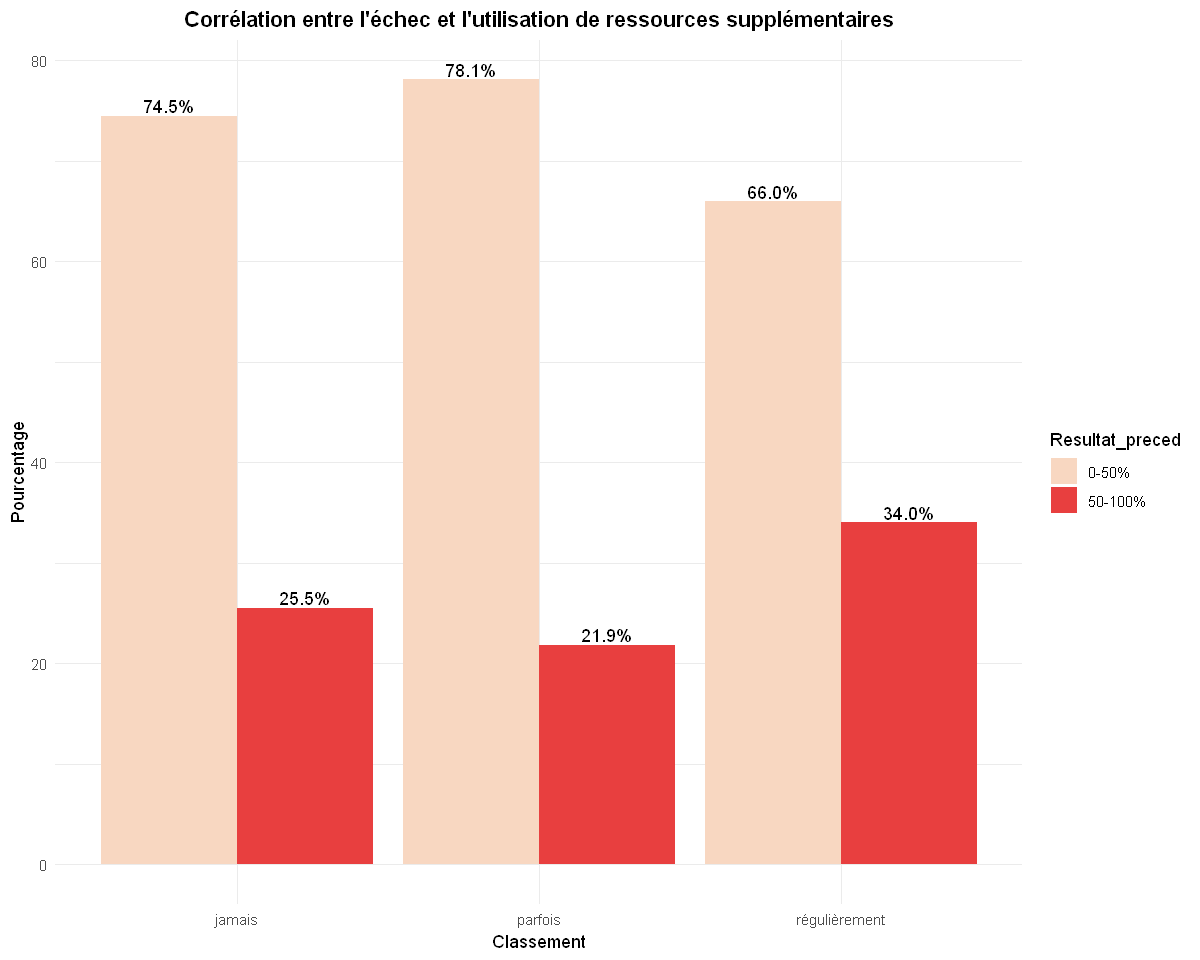

In [328]:
options(repr.plot.width = 10, repr.plot.height = 8)
contingency_table <- insa %>%
  dplyr::count(Resultat_preced, ressources_sup) %>%
  dplyr::group_by(ressources_sup) %>%
  dplyr::mutate(percentage = (n / sum(n)) * 100)
ggplot(contingency_table, aes(x = ressources_sup, y = percentage, fill = Resultat_preced)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_viridis(discrete = TRUE, option = "F", begin = 0.95, end = 0.6) +
  geom_text(aes(label = sprintf("%.1f%%", percentage)), 
            position = position_dodge(width = 0.9), vjust = -0.25) +
  labs(x = "Classement", y = "Pourcentage", title = "Corrélation entre l'échec et l'utilisation de ressources supplémentaires") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

Si on devait résumer en quelques points :
- Les facteurs relatifs au travail ou à la rigueur en cours n'apparaissent plus.
- La dimension sociale prend de l'ampleur : on retrouve la variable surface logement, mais aussi le sommeil. Voir d'autres facteurs dans le rapport projet.
- Enfin, à propos de l'adéquation au projet pro : conformément aux 0-25%, on remarque que plus la satisfaction vis-à-vis du projet pro augmente, plus la part de ceux qui réussisent diminuent, donc une confirmation de ce qu'on observait auparavant : les gens qui réussissent très bien ne se projettent pas forcément et ont du mal à rapprocher leurs études de leur avenir pro. (autre lecture : les 0-10% sont exigents vis à vis de leurs études, quant aux 0-75%, ils sont pessimistes, donc parmi les tout à fait, forte représentativité des 25-75%).